# Initialization

In [1]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def _save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)
    
save_fig = _save_fig

In [2]:
def save_fig(*args, **kwargs):
    kwargs.setdefault('subdir', 'kde')
    return _save_fig(*args, **kwargs)

# Complex

## Different bandwidths per variable

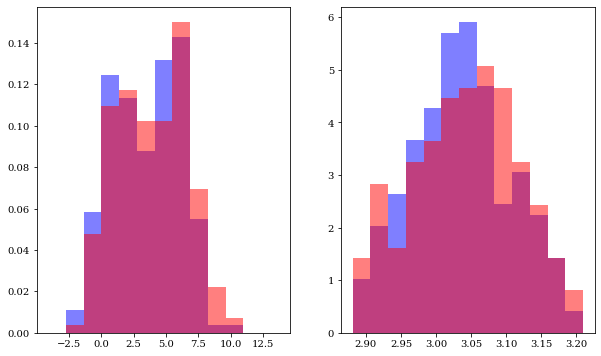

In [3]:
np.random.seed(9235)
NUM = 200
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', np.sqrt(NUM), stretch=1.0) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges, indexing='ij')
xc, yc = np.meshgrid(*cents, indexing='ij')
grid = np.vstack([xc.ravel(), yc.ravel()])

bws = [0.5, 2.0]

kde2d = kale.KDE(data, bandwidth=bws)

kde1d = [kale.KDE(dd, bandwidth=ss) for dd, ss in zip(data, bws)]

fig, axes = plt.subplots(figsize=[10, 6], ncols=2)

for ii in range(2):
    samp_1d = kde1d[ii].resample(NUM).squeeze()
    samp_2d = kde2d.resample(NUM)[ii]

    ks, pv = sp.stats.ks_2samp(samp_1d, samp_2d)

    ax = axes[ii]
    for samp, cc in zip([samp_1d, samp_2d], ['b', 'r']):
        ax.hist(samp, bins=edges[ii], color=cc, density=True, alpha=0.5)    
    
nbshow()

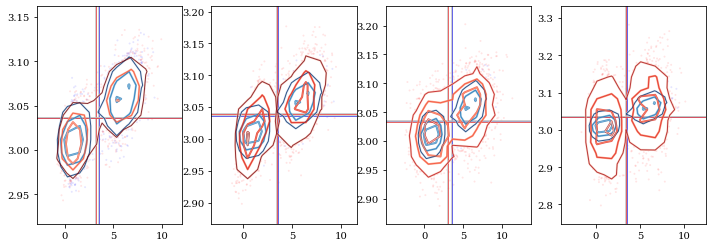

In [4]:
NUM = 2000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', np.sqrt(NUM), stretch=1.0) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges, indexing='ij')
xc, yc = np.meshgrid(*cents, indexing='ij')
grid = np.vstack([xc.ravel(), yc.ravel()])

ss = [0.5, 1.0]
t1 = np.einsum('i,j', ss, ss)
t2 = np.identity(len(ss)) * ss
bws = [0.2, t1, t2, (0.25, 2.)]
fig, axes = plt.subplots(figsize=[12, 4], ncols=len(bws))
levels = sp.stats.norm.cdf([-2, -1, 1, 2])

for ii, (ax, bw) in enumerate(zip(axes, bws)):
    hist, *_ = np.histogram2d(*data, bins=edges, density=True)
    kale.plot.dist2d_data(ax, data=data, color='blue', hist2d=False)
    
    kde = kale.KDE(data, bandwidth=bw)
    pdf = kde.pdf(grid).reshape(hist.shape).T
    samples = kde.resample(NUM)
    kale.plot.dist2d_data(ax, data=samples, color='red', hist2d=False)
    
nbshow()

## Keep Dimensions in Resample

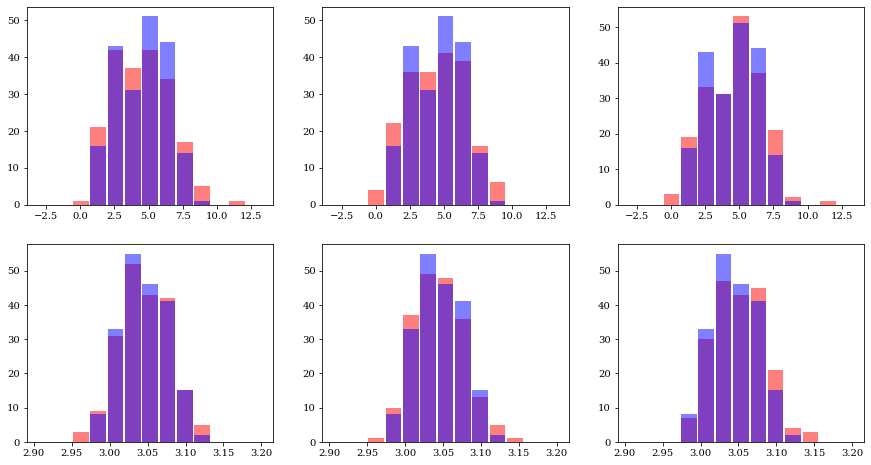

In [5]:
np.random.seed(9235)
NUM = 200
a1 = np.random.normal(6.0, 1.0, NUM//2)
# a2 = np.random.lognormal(0, 0.5, size=NUM//2)
a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', np.sqrt(NUM), stretch=1.0) for dd in data]
kde2d = kale.KDE(data)


fig, axes = plt.subplots(figsize=[15, 8], nrows=2, ncols=3)

norm = 2.3

for ii in range(3):
    test = np.array(data)
    test = np.insert(test, ii, norm*np.ones_like(test[0]), axis=0)

    kde3d = kale.KDE(test)
    
    samples = kde3d.resample(NUM, keep=ii)
    param_samp = samples[ii]
    if not np.allclose(param_samp, norm):
        raise ValueError("Failure!")

    samples = np.delete(samples, ii, axis=0)
    
    for jj in range(2):
        ax = axes[jj, ii]
        stuff = [samples[jj], data[jj]]
        for vals, cc in zip(stuff, ['r', 'b']):
            ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

        ks, pv = sp.stats.ks_2samp(*stuff)
        msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
        # print(msg)
        # zplot.text(ax, msg, loc='ur')
    
nbshow()

In [6]:
# np.random.seed(2234)
# NUM = 300
# a1 = np.random.normal(6.0, 1.0, NUM//2)
# # a2 = np.random.lognormal(0, 0.5, size=NUM//2)
# a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
# aa = np.concatenate([a1, a2])

# bb = np.random.normal(3.0, 0.02, NUM) + aa/100

# data = [aa, bb]
# edges = [kale.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
# kde2d = kale.KDE(data)


# norms = [2.3, -3.4]

# pvals = []
# for ii in range(3):
#     # print("")
#     for jj in range(3):
#         if ii == jj:
#             continue
            
#         lo = np.min([ii, jj])
#         hi = np.max([ii, jj])
#         test = np.array(data)
#         test = np.insert(test, lo, norms[0]*np.ones_like(test[0]), axis=0)
#         test = np.insert(test, hi, norms[1]*np.ones_like(test[0]), axis=0)

#         kde4d = kale.KDE(test)

#         samples = kde4d.resample(NUM, keep=(lo, hi))
# #         for kk, samp in enumerate(samples):
# #             print(ii, jj, kk, zmath.stats_str(samp))
        
#         for kk, ll in enumerate([lo, hi]):
#             param_samps = samples[ll]
#             if not np.allclose(param_samps, norms[kk]):
#                 print(norms[kk], zmath.stats_str(param_samps))
#                 raise ValueError("Failure!")

#         samples = np.delete(samples, (lo, hi), axis=0)

#         for jj in range(2):
#             stuff = [samples[jj], data[jj]]
#             for vals, cc in zip(stuff, ['r', 'b']):
#                 ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

#             ks, pv = sp.stats.ks_2samp(*stuff)
#             msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
#             pvals.append(pv)
#             assert pv > 0.1, print(msg)
            
            
# print(np.min(pvals))
# print(pvals)


# Reflecting Boundaries

## PDF

### 1D

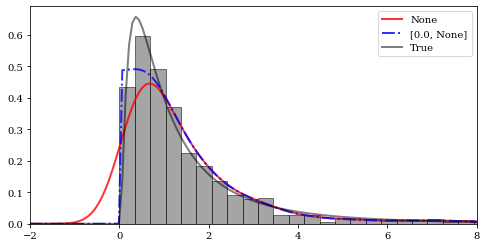

In [7]:
np.random.seed(5142)
NUM = 1000
aa = np.random.lognormal(size=NUM)
# aa = aa[aa < 10.0]

extr = [0.0, 10.0]
edges = kale.utils.spacing(extr, 'lin', 30)
grid = kale.utils.spacing(extr, 'lin', 200, stretch=0.5)

fig, ax = plt.subplots(figsize=[8, 4])

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)


# boundaries = [None, [0.0], [2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
boundaries = [None, [0.0, None]]
lines = ['-', '-.']
colors = ['r', 'b']
pdf = sp.stats.lognorm(1.0).pdf(grid)
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kale.KDE(aa)
    ax.plot(grid, kde.pdf(grid, reflect=bnd), color=cc, ls=ls, lw=2.0, alpha=0.8, label=str(bnd))

ax.plot(grid, pdf, 'k-', label='True', alpha=0.5, lw=2.0)
    
ax.set_xlim([-2, 8])
plt.legend()
nbshow()

Total = 9.9979e-01
Total = 1.0013e+00
Total = 1.0010e+00
Total = 1.0025e+00


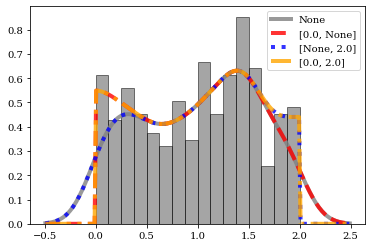

In [8]:
np.random.seed(124)
NUM = 300
extr = [0.0, 2.0]
aa = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', np.sqrt(NUM))
egrid = kale.utils.spacing(extr, 'lin', 200, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)
fig, ax = plt.subplots()

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)

boundaries = [None, [0.0, None], [None, 2.0], extr]
lines = ['-', '--', ':', '-.']
colors = ['0.5', 'red', 'blue', 'orange']
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kale.KDE(aa)
    pdf = kde.pdf(cgrid, reflect=bnd)
    ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
    
    tot = np.sum(pdf * delta)
    print("Total = {:.4e}".format(tot))
    assert np.isclose(tot, 1.0, rtol=1e-2), "Unitarity is violated!"
    
plt.legend()
nbshow()

In [9]:
# np.random.seed(124)
# NUM = 1000
# extr = [0.0, 2.0]
# aa = np.random.uniform(*extr, NUM)

# edges = kale.utils.spacing(extr, 'lin', 14)
# egrid = kale.utils.spacing(extr, 'lin', 1000, stretch=0.5)
# cgrid = kale.utils.midpoints(egrid, 'lin')
# delta = np.diff(egrid)
# fig, ax = plt.subplots(figsize=[10, 8])



# ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)
# for dd in aa:
#     l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)


# boundaries = [None, [0.0, None], [None, 2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
# colors = ['0.5', 'red', 'blue', 'orange']
# for bnd, cc, ls in zip(boundaries, colors, lines):
#     kde = kale.KDE(aa, kernel=kale.kernels.Box, bandwidth=2.0)
#     pdf = kde.pdf(cgrid, reflect=bnd)
#     ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
#     tot = np.sum(pdf * delta)
#     print("Total: {:.4e}".format(tot))
    
# plt.legend()
# nbshow()

### 2D

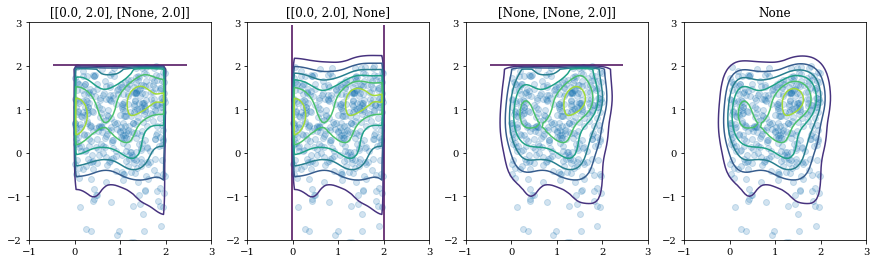

In [10]:
np.random.seed(124)
NUM = 400
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.0, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])

data = [xx, yy]
edges = [kale.utils.spacing(aa, 'lin', np.sqrt(NUM)) for aa in [xx, yy]]
egrid = [kale.utils.spacing(ee, 'lin', 60, stretch=0.5) for ee in edges]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid, indexing='ij')

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[15, 4], ncols=4)

for ax in axes:
    ax.scatter(xx, yy, alpha=0.2)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)


kde = kale.KDE(data)
reflect = [[0.0, 2.0], [None, 2.0]]
pdf_1d = kde.pdf(grid, reflect=reflect)
pdf = pdf_1d.reshape(hist.shape)
# ax.contour(*cgrid, pdf)

inside = True
outside = True
for ii, ref in enumerate(reflect):
    if ref[0] is None:
        ref[0] = -np.inf
    if ref[1] is None:
        ref[1] = np.inf
    inside = inside & (ref[0] < grid[ii]) & (grid[ii] < ref[1])
    outside = outside & ((grid[ii] < ref[0]) | (ref[1] < grid[ii]))
    
assert np.all(pdf_1d[inside] > 0.0), "Inside has zero values!"
assert np.allclose(pdf_1d[outside], 0.0), "Outside has non-zero values!"

area = width[0][:, np.newaxis] * width[1][np.newaxis, :]
prob_tot = np.sum(pdf * area)
assert np.isclose(prob_tot, 1.0, rtol=3e-2), "`prob_tot` = '{}' is not unity!".format(prob_tot)
        
reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
for ii, (ax, reflect) in enumerate(zip(axes, reflections)):
    pdf_1d = kde.pdf(grid, reflect=reflect)
    pdf = pdf_1d.reshape(hist.shape)
    ax.contour(*cgrid, pdf.T)
    
    ax.set(xlim=[-1.0, 3.0], ylim=[-2, 3], title=str(reflect))
    
nbshow()

## Resampling

### 1D

reflect = 'None', outside = 'True'
reflect = '[0.0, 2.0]', outside = 'False'
ks = '0.036', pv = '0.5362766985932181'


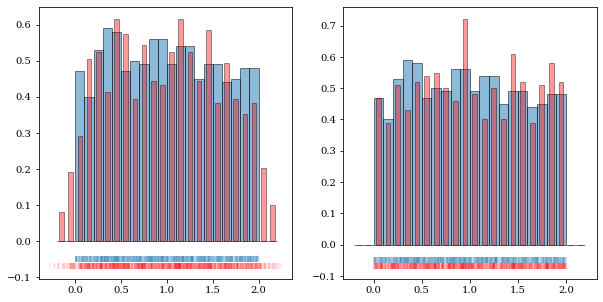

In [11]:
np.random.seed(1245)
NUM = 1000

extr = [0.0, 2.0]
data = np.random.uniform(*extr, NUM)
fig, axes = plt.subplots(figsize=[10, 5], ncols=2)

# edges = np.linspace(-0.4, 2.4, 20)
edges = np.linspace(-0.2, 2.2, 25)

for ax in axes:
    ax.scatter(data, -0.05*np.ones_like(data), alpha=0.1, marker='|')
    ax.hist(data, bins=edges, density=True, edgecolor='k', alpha=0.5)

kde = kale.KDE(data)

reflections = [None, extr]
for ii, reflect in enumerate(reflections):
    samp = kde.resample(NUM, reflect=reflect)
    axes[ii].scatter(samp, -0.07*np.ones_like(samp), alpha=0.1, color='r', marker='|')
    axes[ii].hist(samp, bins=edges, density=True, edgecolor='k', alpha=0.4, color='r', rwidth=0.5)
    
    some_outside = np.any((samp < extr[0]) + (extr[1] < samp))
    print("reflect = '{}', outside = '{}'".format(reflect, some_outside))
    if reflect is None:
        # There should be some samples outside
        tools.assert_true(some_outside)
    else:
        # There should not be any samples outside
        tools.assert_false(some_outside)
        ks, pv = sp.stats.ks_2samp(data, samp)
        print("ks = '{}', pv = '{}'".format(ks, pv))
        # Check new sample is consistent
        tools.assert_true(pv > 0.1)


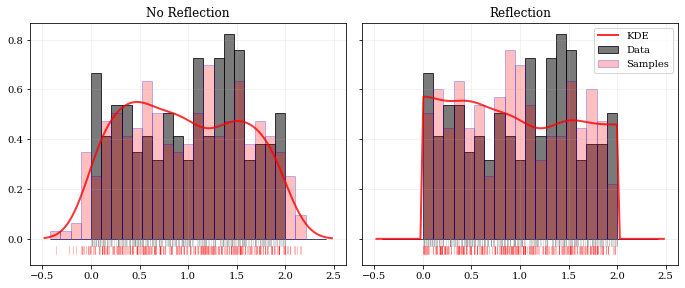

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_1d_reflect.png'


In [12]:
np.random.seed(1245)
NUM = 300

extr = [0.0, 2.0]
data = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', 20)
edges = np.concatenate([
    edges[0] - np.arange(1, 5)[::-1]*np.diff(edges)[0],
    edges,
    edges[-1] + np.arange(1, 5)*np.diff(edges)[-1],
])

egrid = kale.utils.spacing(data, 'lin', 100, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)

fig, axes = plt.subplots(figsize=[10, 4], ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

kde = kale.KDE(data)

reflections = [None, extr]
titles = ['No Reflection', 'Reflection']
for ii, reflect in enumerate(reflections):
    ax = axes[ii]
    ax.grid(alpha=0.2)
    ax.set_title(titles[ii])
    *_, l0 = ax.hist(aa, bins=edges, alpha=0.75, color='0.3', edgecolor='k', density=True)
    pdf = kde.pdf(cgrid, reflect=reflect)
    l1, = ax.plot(cgrid, pdf, color='r', ls='-', lw=2.0, alpha=0.8)
    for dd in data:
        l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)
    
    samp = kde.resample(NUM, reflect=reflect)
    *_, l3 = ax.hist(samp, bins=edges, alpha=0.25, color='r', edgecolor='b', density=True)
    for ss in samp:
        l4, = ax.plot([ss, ss], [-0.03, -0.06], color='r', alpha=0.5, lw=0.5)
    
    some_outside = np.any((samp < extr[0]) + (extr[1] < samp))
    if reflect is None:
        assert some_outside, "There should be some samples outside!"
    else:
        assert (not some_outside), "There should not be any samples outside!"
        ks, pv = sp.stats.ks_2samp(data, samp)
        assert (pv > 0.4), "New sample is inconsistent!"
        
lines = [l1, l0[0], l3[0]]
names = ['KDE', 'Data', 'Samples']
plt.legend(lines, names)
nbshow()

fname = 'kde_1d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

### 2D

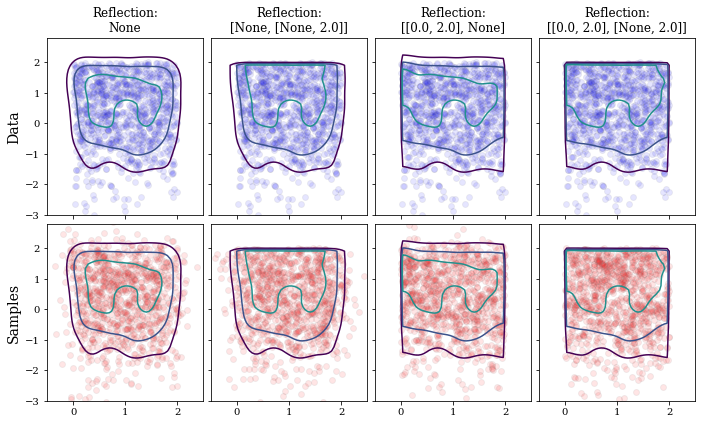

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_2d_reflect.png'


In [13]:
seed = np.random.randint(int(1e4))
seed = 8067
# print(seed)
np.random.seed(seed)
NUM = 1000

# Create 2D data
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.5, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])
data = [xx, yy]

# Create bin-edges, centers, grid, and bin-widths for each dimension
# edges = [kale.utils.spacing(aa, 'lin', 30) for aa in [xx, yy]]
# egrid = [kale.utils.spacing(ee, 'lin', 100, stretch=0.5) for ee in edges]
egrid = [kale.utils.spacing(aa, 'lin', 60, stretch=0.5) for aa in data]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid, indexing='ij')

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[10, 6], ncols=4, nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)

levels = [0.05, 0.1, 0.15, 0.2, 0.25]

kde = kale.KDE(data)

reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
kw = dict(edgecolor='0.5', alpha=0.1)
fs = 14
for ii, (axcol, reflect) in enumerate(zip(axes.T, reflections[::-1])):
    title = "Reflection:\n" + str(reflect)
    ylab = None
    pdf_1d = kde.pdf(grid, reflect=reflect)
    pdf = pdf_1d.reshape(hist.shape)
    uu, vv = kde.resample(reflect=reflect)
    for jj, ax in enumerate(axcol):
        if jj == 0:
            if ii == 0:
                ylab = 'Data'                 
            ax.scatter(xx, yy, facecolor='b', **kw)
            ax.set_title(title)
        else:
            if ii == 0:
                ylab = 'Samples'                 
            ax.scatter(uu, vv, facecolor='r', **kw)

        ax.contour(*cgrid, pdf.T, zorder=10, levels=levels)
        ax.set(xlim=[-0.5, 2.5], ylim=[-3, 2.8])
        ax.set_ylabel(ylab, size=fs)
        
nbshow()

fname = 'kde_2d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

# Particular Axes/Dimensions

Construct Data

In [14]:
NUM = 3000
# bandwidth = 0.2

sigma = [1.0, 0.2, 1.5]
corr = [
    [+1.0, +0.8, +0.4],
    [+0.8, +1.0, -0.5],
    [+0.2, -0.5, +1.0]
]

s2 = np.square(sigma)

cov = np.zeros_like(corr)
for (ii, jj), cc in np.ndenumerate(corr):
    cov[ii, jj] = cc * sigma[ii] * sigma[jj]

data = np.random.multivariate_normal(np.zeros_like(sigma), cov, NUM).T
dd = data[1, :]
dd = (dd - dd.min())/dd.max()
data *= np.sqrt(dd)[np.newaxis, :]

pc = 0
extr = [np.percentile(dd, [0+pc, 100-pc]) for dd in data]
noise = [np.random.uniform(*ex, NUM//5) for ex in extr]
data = np.append(data, noise, axis=1)

/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


Plot Data and KDE Contours

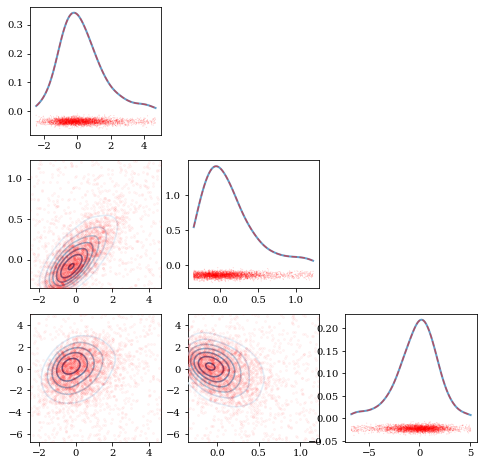

In [15]:
NEDGE = 100
FIGSIZE = 8

edges = [np.linspace(xx.min(), xx.max(), NEDGE+1+ii) for ii, xx in enumerate(data)]
kde = kale.KDE(data)
npars = len(edges)

fig, axes = plt.subplots(figsize=[FIGSIZE, FIGSIZE], ncols=npars, nrows=npars)
for (ii, jj), ax in np.ndenumerate(axes):
    if jj > ii:
        ax.set_visible(False)
        continue
        
    xe = edges[jj]
    dx = data[jj]
    
    if ii == jj:
        pdf = kde.pdf(xe, params=[jj])
        ax.plot(xe, pdf, lw=2.0, alpha=0.7)
    
        bw = kde.kernel.bandwidth[jj, jj]
        kde_1d = kale.KDE(data[jj], bandwidth=bw)
        ax.plot(xe, kde_1d.pdf(xe), 'r--', alpha=0.5)
    
        kale.plot.draw_carpet(dx, ax=ax, color='r')
    
    else:
        ye = edges[ii]
        dy = data[ii]
        pdf = kde.pdf_grid([xe, ye], params=[jj, ii])
        xx, yy = np.meshgrid(xe, ye, indexing='ij')

        # ax.pcolormesh(xx, yy, pdf, cmap='Blues_r')
        ax.contour(xx, yy, pdf, cmap='Blues', alpha=0.8, zorder=4)
        ax.scatter(dx, dy, color='r', alpha=0.03, s=4, zorder=10)
    
nbshow()

# Other Kernels

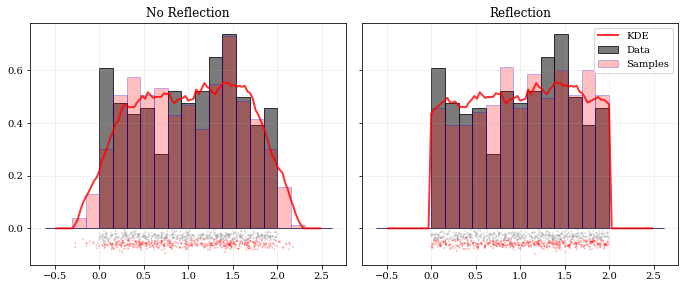

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_1d_reflect.png'


In [16]:
np.random.seed(12345)
NUM = 500

extr = [0.0, 2.0]
data = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', 14)
edges = np.concatenate([
    edges[0] - np.arange(1, 5)[::-1]*np.diff(edges)[0],
    edges,
    edges[-1] + np.arange(1, 5)*np.diff(edges)[-1],
])

egrid = kale.utils.spacing(data, 'lin', 100, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)

fig, axes = plt.subplots(figsize=[10, 4], ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

kde = kale.KDE(data, kernel=kale.kernels.Box_Asym, bandwidth=0.5)

reflections = [None, extr]
titles = ['No Reflection', 'Reflection']
for ii, reflect in enumerate(reflections):
    ax = axes[ii]
    ax.grid(alpha=0.2)
    ax.set_title(titles[ii])
    *_, l0 = ax.hist(aa, bins=edges, alpha=0.75, color='0.3', edgecolor='k', density=True)
    pdf = kde.pdf(cgrid, reflect=reflect)
    l1, = ax.plot(cgrid, pdf, color='r', ls='-', lw=2.0, alpha=0.8)
#     for dd in data:
#         l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)
    kale.plot.draw_carpet(data, ax=ax, color='0.5', yave=-0.03, ystd=0.01)

    tot = np.sum(pdf*delta)
    
    samp = kde.resample(NUM, reflect=reflect)
    *_, l3 = ax.hist(samp, bins=edges, alpha=0.25, color='r', edgecolor='b', density=True)
#     for ss in samp:
#         l4, = ax.plot([ss, ss], [-0.03, -0.06], color='r', alpha=0.5, lw=0.5)
    kale.plot.draw_carpet(samp, ax=ax, color='r', yave=-0.06, ystd=0.01)
    
    some_outside = np.any((samp < extr[0]) + (extr[1] < samp))
    if reflect is None:
        assert some_outside, "There should be some samples outside!"
    else:
        assert (not some_outside), "There should not be any samples outside!"
        ks, pv = sp.stats.ks_2samp(data, samp)
        assert (pv > 0.4), "New sample is inconsistent!"

    assert np.isclose(tot, 1.0, rtol=2e-2), "Unitarity violated!  Prob tot: {:.4e}".format(tot)

lines = [l1, l0[0], l3[0]]
names = ['KDE', 'Data', 'Samples']
plt.legend(lines, names)
nbshow()

fname = 'kde_1d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

reflect: None, inside: (0.00e+00, 0.00e+00, 1.85e-02, 1.30e-01, 2.50e-01), for (0%, 16%, 50%, 84%, 100%)
1 None prob_tot = 1.0022e+00
	 (0.00e+00, 0.00e+00, 1.85e-02, 1.30e-01, 2.50e-01), for (0%, 16%, 50%, 84%, 100%)
reflect: [None, [-inf, 2.0]], inside: (0.00e+00, 0.00e+00, 2.78e-02, 1.48e-01, 2.50e-01), for (0%, 16%, 50%, 84%, 100%)
1 [None, [-inf, 2.0]] prob_tot = 1.0031e+00
	 (0.00e+00, 0.00e+00, 9.25e-03, 1.39e-01, 2.50e-01), for (0%, 16%, 50%, 84%, 100%)
reflect: [[0.0, 2.0], None], inside: (0.00e+00, 0.00e+00, 5.55e-02, 1.57e-01, 2.96e-01), for (0%, 16%, 50%, 84%, 100%)
1 [[0.0, 2.0], None] prob_tot = 1.0109e+00
	 (0.00e+00, 0.00e+00, 0.00e+00, 1.39e-01, 2.96e-01), for (0%, 16%, 50%, 84%, 100%)
reflect: [[0.0, 2.0], [-inf, 2.0]], inside: (0.00e+00, 0.00e+00, 8.33e-02, 1.67e-01, 2.96e-01), for (0%, 16%, 50%, 84%, 100%)
1 [[0.0, 2.0], [-inf, 2.0]] prob_tot = 1.0117e+00
	 (0.00e+00, 0.00e+00, 0.00e+00, 1.48e-01, 2.96e-01), for (0%, 16%, 50%, 84%, 100%)


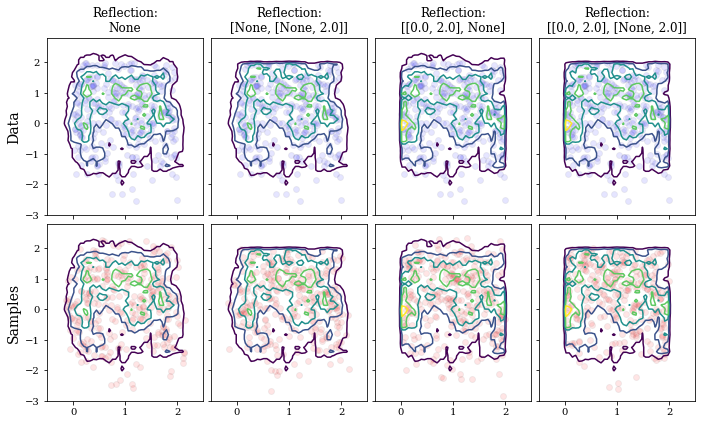

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_2d_reflect.png'


In [17]:
seed = np.random.randint(int(1e4))
seed = 8067
# print(seed)
np.random.seed(seed)
NUM = 300
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.5, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])

data = [xx, yy]
edges = [kale.utils.spacing(aa, 'lin', 20) for aa in [xx, yy]]
egrid = [kale.utils.spacing(ee, 'lin', 50, stretch=0.5) for ee in edges]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid, indexing='ij')

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[10, 6], ncols=4, nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)

levels = [0.05, 0.1, 0.15, 0.2, 0.25]

kde = kale.KDE(data, kernel='box')
inside_test_func = np.all if not kde.kernel.FINITE else np.any

reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
kw = dict(edgecolor='0.5', alpha=0.1)
fs = 14
for ii, (axcol, reflect) in enumerate(zip(axes.T, reflections[::-1])):
    title = "Reflection:\n" + str(reflect)
    ylab = None
    pdf_1d = kde.pdf(grid, reflect=reflect)
    pdf = pdf_1d.reshape(hist.shape)
    uu, vv = kde.resample(reflect=reflect)
    for jj, ax in enumerate(axcol):
        if jj == 0:
            if ii == 0:
               ylab = 'Data'                 
            ax.scatter(xx, yy, facecolor='b', **kw)
            ax.set_title(title)
        else:
            if ii == 0:
               ylab = 'Samples'                 
            ax.scatter(uu, vv, facecolor='r', **kw)

        ax.contour(*cgrid, pdf.T, zorder=10, levels=levels)
        ax.set(xlim=[-0.5, 2.5], ylim=[-3, 2.8])
        ax.set_ylabel(ylab, size=fs)
        
    inside = np.ones_like(pdf_1d, dtype=bool)
    if reflect is None:
        outside = np.zeros_like(pdf_1d, dtype=bool)
    else:
        outside = np.ones_like(pdf_1d, dtype=bool)
        for ii, ref in enumerate(reflect):
            if ref is None:
                ref = [-np.inf, np.inf]
            if ref[0] is None:
                ref[0] = -np.inf
            if ref[1] is None:
                ref[1] = np.inf
            inside = inside & (ref[0] < grid[ii]) & (grid[ii] < ref[1])
            outside = outside & ((grid[ii] < ref[0]) | (ref[1] < grid[ii]))

    print("reflect: {}, inside: {}".format(reflect, kale.utils.stats_str(pdf_1d[inside])))
    tools.assert_true(inside_test_func(pdf_1d[inside] > 0.0))
    tools.assert_true(np.allclose(pdf_1d[outside], 0.0))

    area = width[0][:, np.newaxis] * width[1][np.newaxis, :]
    prob_tot = np.sum(pdf * area)
    print(jj, reflect, "prob_tot = {:.4e}".format(prob_tot))
    print("\t", kale.utils.stats_str(pdf))
    tools.assert_true(np.isclose(prob_tot, 1.0, rtol=3e-2))
        

nbshow()

fname = 'kde_2d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

# Derived Statistics

## CDF - Cumulative DF

### 1D

In [18]:
def check_1d_samples_cdf(samples, xx, tru_cdf, tru_pdf=None):
    xx = np.asarray(xx)
    # Construct KDE and calculate CDF
    kde = kale.KDE(samples)    
    kde_cdf = kde.cdf(xx)
    # Calculate error relative to true CDF
    kde_err = np.fabs(1 - kde_cdf/tru_cdf)

    # Create and Setup Figure/Axes
    fig, axes = plt.subplots(figsize=[12, 6], ncols=2)
    # tw = ax.twinx()
    ax = axes[0]
    tw = axes[1]
    tw.set_yscale('log')

    kde_pdf = kde.pdf(xx)
    if tru_pdf is not None:
        norm = tru_pdf.max()
        ax.plot(xx, tru_pdf / norm, 'k--', alpha=0.5)
    else:
        norm = kde_pdf.max()
        
    ax.plot(xx, kde_pdf / norm, 'b--', alpha=0.5)
    
    ax.plot(xx, tru_cdf, 'k-', lw=3.0, alpha=0.6)
    ax.plot(xx, kde_cdf, 'b-', lw=2.0, alpha=0.7)
    tw.plot(xx, kde_err, 'r-', lw=3.0, alpha=0.7, label='kde error')

    # Calculate an "expected" error based on Poisson statistics
    zz = np.sort(samples)
    cnt = np.arange(1, zz.size+1)
    # Poisson error up to each sample-point
    err = 1 / np.sqrt(cnt)
    # Interpolate to test-points, and scale by number of bins up to each bin
    err_samp = np.interp(xx, zz, err) / np.sqrt(np.arange(1, len(xx)+1))
    # Calculate a fractional, integrated error measure
    # This is the excess of KDE error above expected
    int_err = np.clip(kde_err - err_samp, 0.0, None)
    _xx = (xx - ave) / std
    int_err = kale.utils.cumtrapz(int_err, _xx) / (_xx.max() - _xx.min())
    tot_err = int_err[-1]
    print("tot err  = ", tot_err)
    
    tw.plot(xx, err_samp, 'r--', lw=3.0, alpha=0.5, label='expected error')
    tw.fill_between(xx, 0.0, err_samp, color='r', alpha=0.1)
    tw.plot(xx, int_err, 'r-.', label='Frac Int Err')

    tw.legend()  # loc='center left', title='Right Axes')
    
    if tot_err > 0.1:
        warnings.warn("Error {:.2e} is large".format(tot_err))
        if tot_err > 0.2:
            raise ValueError("Error {:.2e} is unexceptably large!".format(tot_err))
    
    return fig

### 1D Normal Distribution

Normal Distribution: 2.42e-01 ± 1.75e+00
tot err  =  0.11525417496489872


/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Error 1.15e-01 is large


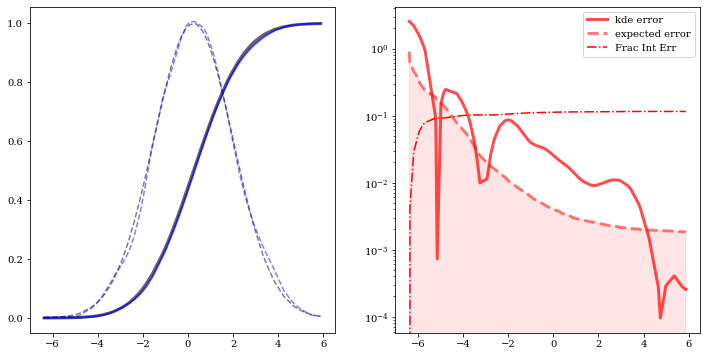

In [19]:
NUM_POINTS = 3e3
NUM_PDF = 1e2
np.random.seed(1234)

# Construct random values
ave, std = 10**np.random.uniform(-1, 1, 2)
print("Normal Distribution: {:.2e} ± {:.2e}".format(ave, std))
# Choose random samples
samples = np.random.normal(ave, std, size=int(NUM_POINTS))
# Choose test-points (x-axis values)
xx = sorted(np.random.uniform(samples.min(), samples.max(), int(NUM_PDF)))
# Find the "true" CDF
tru_cdf = sp.stats.norm.cdf(xx, ave, std)
tru_pdf = sp.stats.norm.pdf(xx, ave, std)

# Perform Test
fig = check_1d_samples_cdf(samples, xx, tru_cdf, tru_pdf)
nbshow()

### 1D Uniform Distribution

Uniform Distribution: 7.83e-01 ± 1.16e+00
tot err  =  0.04297327611167875


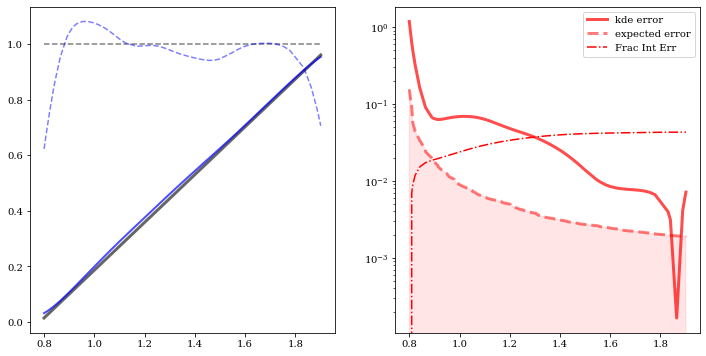

In [20]:
NUM_POINTS = 3e3
NUM_PDF = 1e2
np.random.seed(4321234)

# Construct random values
ave, std = 10**np.random.uniform(-1, 1, 2)
print("Uniform Distribution: {:.2e} ± {:.2e}".format(ave, std))
# Choose random samples
samples = np.random.uniform(ave, ave+std, size=int(NUM_POINTS))
# Choose test-points (x-axis values)
xx = sorted(np.random.uniform(samples.min(), samples.max(), int(NUM_PDF)))
# Find the "true" CDF
tru_cdf = sp.stats.uniform.cdf(xx, ave, std)
tru_pdf = sp.stats.uniform.pdf(xx, ave, std)

# Perform Test
fig = check_1d_samples_cdf(samples, xx, tru_cdf, tru_pdf)
nbshow()

### 1D Composite

Distribution params: 3.63e-01 ± 2.35e-01
tot err  =  0.10472614648037606


/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Error 1.05e-01 is large


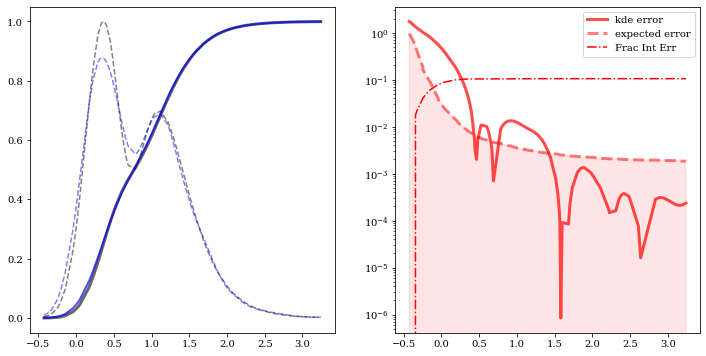

In [21]:
NUM_POINTS = 3e3
NUM_PDF = 1e2
np.random.seed(4321234)

# Construct random values
# ave, std = 10**np.random.uniform(-1, 1, 2)
ave = 3.63e-01
std = 2.35e-01
print("Distribution params: {:.2e} ± {:.2e}".format(ave, std))

# Choose random samples
n1 = int(NUM_POINTS*0.5)
n2 = int(NUM_POINTS - n1)
a1 = np.random.normal(ave, std, n1)
# a2 = np.random.lognormal(ave, std, size=n2)
a2 = sp.stats.lognorm.ppf(np.random.uniform(0, 1, n2), ave, std)
samples = np.concatenate([a1, a2])

# edges, pdf = kale.pdf(aa)
# plt.plot(edges, pdf)

# Choose test-points (x-axis values)
xx = sorted(np.random.uniform(samples.min(), samples.max(), int(NUM_PDF)))
# Find the "true" CDF
c1 = sp.stats.norm.cdf(xx, ave, std) * n1 / (n1 + n2)
c2 = sp.stats.lognorm.cdf(xx, ave, std) * n2 / (n1 + n2)
tru_cdf = c1 + c2

p1 = sp.stats.norm.pdf(xx, ave, std) * n1 / (n1 + n2)
p2 = sp.stats.lognorm.pdf(xx, ave, std) * n2 / (n1 + n2)
tru_pdf = p1 + p2

# Perform Test
fig = check_1d_samples_cdf(samples, xx, tru_cdf, tru_pdf)
nbshow()

### 2D

In [22]:
def check_2d_samples_cdf(samples, edges, tru_cdf, tru_pdf=None):
    xx = np.asarray(xx)
    # Construct KDE and calculate CDF
    kde = kale.KDE(samples)    
    kde_cdf = kde.cdf(xx)
    # Calculate error relative to true CDF
    kde_err = np.fabs(1 - kde_cdf/tru_cdf)

    # Create and Setup Figure/Axes
    fig, axes = plt.subplots(figsize=[12, 6], ncols=2)
    # tw = ax.twinx()
    ax = axes[0]
    tw = axes[1]
    tw.set_yscale('log')

    kde_pdf = kde.pdf(xx)
    if tru_pdf is not None:
        norm = tru_pdf.max()
        ax.plot(xx, tru_pdf / norm, 'k--', alpha=0.5)
    else:
        norm = kde_pdf.max()
        
    ax.plot(xx, kde_pdf / norm, 'b--', alpha=0.5)
    
    ax.plot(xx, tru_cdf, 'k-', lw=3.0, alpha=0.6)
    ax.plot(xx, kde_cdf, 'b-', lw=2.0, alpha=0.7)
    tw.plot(xx, kde_err, 'r-', lw=3.0, alpha=0.7, label='kde error')

    # Calculate an "expected" error based on Poisson statistics
    zz = np.sort(samples)
    cnt = np.arange(1, zz.size+1)
    # Poisson error up to each sample-point
    err = 1 / np.sqrt(cnt)
    # Interpolate to test-points, and scale by number of bins up to each bin
    err_samp = np.interp(xx, zz, err) / np.sqrt(np.arange(1, len(xx)+1))
    # Calculate a fractional, integrated error measure
    # This is the excess of KDE error above expected
    int_err = np.clip(kde_err - err_samp, 0.0, None)
    _xx = (xx - ave) / std
    int_err = kale.utils.cumtrapz(int_err, _xx) / (_xx.max() - _xx.min())
    tot_err = int_err[-1]
    print("tot err  = ", tot_err)
    
    tw.plot(xx, err_samp, 'r--', lw=3.0, alpha=0.5, label='expected error')
    tw.fill_between(xx, 0.0, err_samp, color='r', alpha=0.1)
    tw.plot(xx, int_err, 'r-.', label='Frac Int Err')

    tw.legend()  # loc='center left', title='Right Axes')
    
    if tot_err > 0.1:
        warnings.warn("Error {:.2e} is large".format(tot_err))
        if tot_err > 0.2:
            raise ValueError("Error {:.2e} is unexceptably large!".format(tot_err))
    
    return fig

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/kde/2d-gaussian_cdf-test.pdf'


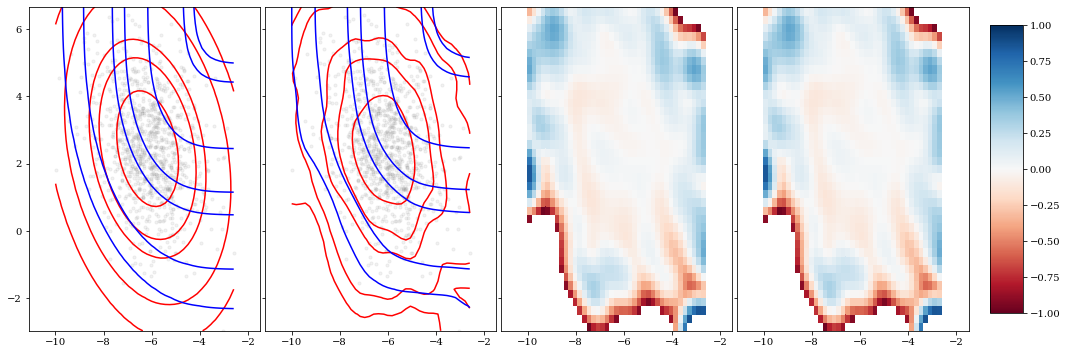

In [23]:
NUM_PTS = 1e3
NUM_EDGES = 40
np.random.seed(1234)

aves = np.random.uniform(-10, 10, 2)
stds = np.random.uniform(0.0, 3.0, 2)
cov = np.random.uniform(-1.0, 1.0, (2,2))
cov[np.arange(2), np.arange(2)] = stds
cov[1, 0] = cov[0, 1]

# print(aves)
# print(cov)

dist = sp.stats.multivariate_normal(aves, cov)
samples = dist.rvs(int(NUM_PTS)).T
# print(samples.shape)
edges = [[xx.min(), xx.max()] for xx in samples]
edges = [np.linspace(*ex, int(NUM_EDGES)) for ex in edges]
edges = np.array(edges)

xx, yy = np.meshgrid(*edges, indexing='ij')
grid = np.moveaxis([xx, yy], 0, -1)

pdf = dist.pdf(grid)
cdf = dist.cdf(grid)
# print("pdf = ", kale.utils.stats_str(pdf))
# print("cdf = ", kale.utils.stats_str(cdf))

pdf_levels = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 0.1]
cdf_levels = [1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.9, 0.95]

kde = kale.KDE(samples)

kde_pdf = kde.pdf_grid(edges)
kde_cdf = kde.cdf_grid(edges)

pdf_rat = kde_pdf / pdf
cdf_rat = kde_cdf / cdf

ratios = np.array([pdf_rat, cdf_rat])
idx = (ratios != 0.0)
rextr = [np.min(ratios[idx]), np.max(ratios[idx])]
# print("Ratio extrema = ", rextr)

pdf_rat = np.log10(pdf_rat)
cdf_rat = np.log10(cdf_rat)
rextr = [-1.0, 1.0]


fig, axes = plt.subplots(figsize=[15, 5], ncols=4, sharex=True, sharey=True)
plt.subplots_adjust(bottom=0.05, left=0.03, right=0.9, top=0.95, wspace=0.02)
cbax = fig.add_axes([0.92, 0.1, 0.03, 0.8])

for ax in axes[:2]:
    ax.scatter(*samples, alpha=0.1, s=10, color='0.5')

ax = axes[0]
ax.contour(xx, yy, pdf, colors='r', levels=pdf_levels)  # cmap='Reds', 
ax.contour(xx, yy, cdf, colors='b', levels=cdf_levels)  # cmap='Blues', 

ax = axes[1]
ax.contour(xx, yy, kde_pdf, colors='r', levels=pdf_levels)  # cmap='Reds', 
ax.contour(xx, yy, kde_cdf, colors='b', levels=cdf_levels)  # cmap='Blues', 

ax = axes[2]
smap = kale.plot._get_smap(rextr, cmap='RdBu')

for ax, rat in zip(axes[2:], ratios):
    pcm = ax.pcolormesh(xx, yy, pdf_rat, cmap=smap.cmap, norm=smap.norm)

plt.colorbar(smap, cax=cbax, orientation='vertical')

ax = axes[0]
xlim = ax.get_xlim()
ylim = ax.get_ylim()
wid = 0.5 * np.max([xx[1] - xx[0] for xx in [xlim, ylim]])
cen = [0.5*(xx[1] + xx[0]) for xx in [xlim, ylim]]
lims = [[cc - wid, cc + wid] for cc in cen]
for ff, ll in zip(['set_xlim', 'set_ylim'], lims):
    getattr(ax, ff)(ll)

    
fname = "2d-gaussian_cdf-test.pdf"
save_fig(fig, fname)
nbshow()